In [2]:
import numpy as np # linear algebra
import pytorch_lightning as pl 
import torch.nn as nn 
import matplotlib.pyplot as plt
from src.ptp.globals import TARGET_DATA_DIR, TRAINING_DIR
import os 
import torch
import nibabel as nib  
from monai.data import MetaTensor
from skimage.metrics import structural_similarity

from src.ptp.models.building_blocks import InvertedResidual, ResNetBlock3D, ConvBNReLU

from pathlib import Path
from src.ptp.evaluation.visualization import visualize_slices, visualize_volumes
from src.ptp.models.gan.generator import Generator
from src.ptp.models.gan.discriminator import Discriminator
from src.ptp.models.gan.gan import GAN
from src.ptp.models.utils import num_trainable_params, num_params

import os
from pathlib import Path


In [2]:
len(os.listdir(TRAINING_DIR))

2

In [3]:
discriminator = Discriminator(1)

In [4]:
print(num_params(discriminator))
print(num_trainable_params(discriminator))

1192816
1192816


In [5]:
input_pt = torch.rand((10, 1, 256, 256, 256))

In [6]:
discriminator(input_pt).shape

torch.Size([10, 1])

The authors used inverted resnet block

In [7]:
sample_tensor = torch.randn((1, 3, 10, 10, 10))

In [25]:
inv_residual = InvertedResidual(3, oup=3, stride=1, expand_ratio=0.5)
output = inv_residual(sample_tensor)

In [26]:
output.shape

torch.Size([1, 3, 10, 10, 10])

In [10]:
resnet_block = ResNetBlock3D(3, nn.ReLU)

In [11]:
resnet_input = torch.randn((1, 3, 10, 10, 10))
resnet_result = resnet_block(resnet_input)

In [12]:
resnet_result.shape

torch.Size([1, 3, 10, 10, 10])

In [13]:
t1 = torch.randn((1, 3, 10, 10, 10))
t2 = torch.randn((1, 3, 10, 10, 10))

torch.cat([t1, t2], axis=1).shape

torch.Size([1, 6, 10, 10, 10])

In [14]:
gen = Generator()

In [15]:
t1 = torch.randn((1, 1, 256, 256, 256))

In [16]:
output = gen(t1)

In [17]:
output.shape

torch.Size([1, 1, 256, 256, 256])

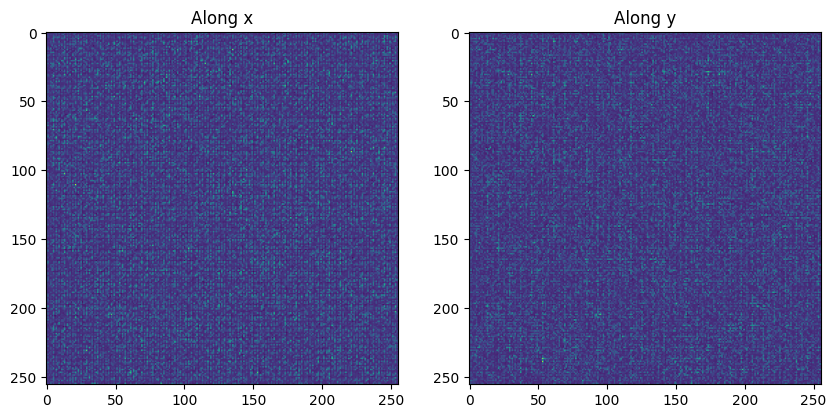

In [18]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.title('Along x')
plt.imshow(output[0, 0, 0, ...].detach().numpy())
plt.subplot(1, 2, 2)
plt.title('Along y')
plt.imshow(output[0, 0, :, 100, :].detach().numpy())

In [19]:
output.mean()

tensor(0.3120, grad_fn=<MeanBackward0>)

### GAN training
The input to the generator is a corrupted image with some added random noise. 

In [3]:
percentile = 5

In [4]:
gan = GAN(percentile)

In [5]:
print(num_trainable_params(gan.G))
print(num_trainable_params(gan.D))

571747
410096


In [6]:
max_epochs = 10

checkpoint_dir = Path(TRAINING_DIR / 'gan')

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=checkpoint_dir, filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}', 
                                      monitor='val_loss', save_last=True) 
early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', verbose=True)

trainer = pl.Trainer(
    max_epochs=max_epochs,
    default_root_dir=checkpoint_dir,
    fast_dev_run=False, num_sanity_val_steps=0
)

trainer.fit(gan)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type          | Params
---------------------------------------
0 | G    | Generator     | 571 K 
1 | D    | Discriminator | 410 K 
---------------------------------------
981 K     Trainable params
0         Non-trainable params
981 K     Total params
3.927     Total estimated model params size (MB)
Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 1/1 [00:27<00:00,  0.04it/s, v_num=1, g_loss_step=0.702, d_loss_step=0.543, train_loss_step=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1/1 [00:31<00:00,  0.03it/s, v_num=1, g_loss_step=0.558, d_loss_step=0.806, train_loss_step=1.360, g_loss=0.901, d_loss=0.663, val_loss=1.560, g_loss_epoch=0.702, d_loss_epoch=0.543, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:32<00:00,  0.03it/s, v_num=1, g_loss_step=0.794, d_loss_step=0.730, train_loss_step=1.520, g_loss=0.937, d_loss=0.657, val_loss=1.590, g_loss_epoch=0.558, d_loss_epoch=0.806, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:29<00:00,  0.03it/s, v_num=1, g_loss_step=0.664, d_loss_step=0.472, train_loss_step=1.140, g_loss=1.080, d_loss=0.637, val_loss=1.720, g_loss_epoch=0.794, d_loss_epoch=0.730, train_loss_epoch=1.520]
Validation: |          | 0/? [00:00<?,

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:51<00:00,  0.02it/s, v_num=1, g_loss_step=0.929, d_loss_step=0.688, train_loss_step=1.620, g_loss=0.975, d_loss=0.671, val_loss=1.650, g_loss_epoch=0.929, d_loss_epoch=0.688, train_loss_epoch=1.620]


In [7]:
gan.discriminator_real_loss

[tensor(0.5897, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.7077, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.9205, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.5574, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.5330, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(1.0117, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.7511, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.4891, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.3634, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.8303, grad_fn=<BinaryCrossEntropyBackward0>)]

In [15]:
def plot_losses(gan_net, n_epochs):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(n_epochs), np.array([x.cpu().detach().numpy() for x in gan_net.discriminator_real_loss]))
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(n_epochs), np.array([x.cpu().detach().numpy() for x in gan_net.discriminator_fake_loss]))

In [9]:
np.array([x.cpu().detach().numpy() for x in gan.discriminator_fake_loss])

array([0.49603748, 0.9034738 , 0.5385504 , 0.38563415, 0.66718197,
       1.1227548 , 0.537673  , 1.1284735 , 0.6845829 , 0.5463495 ],
      dtype=float32)

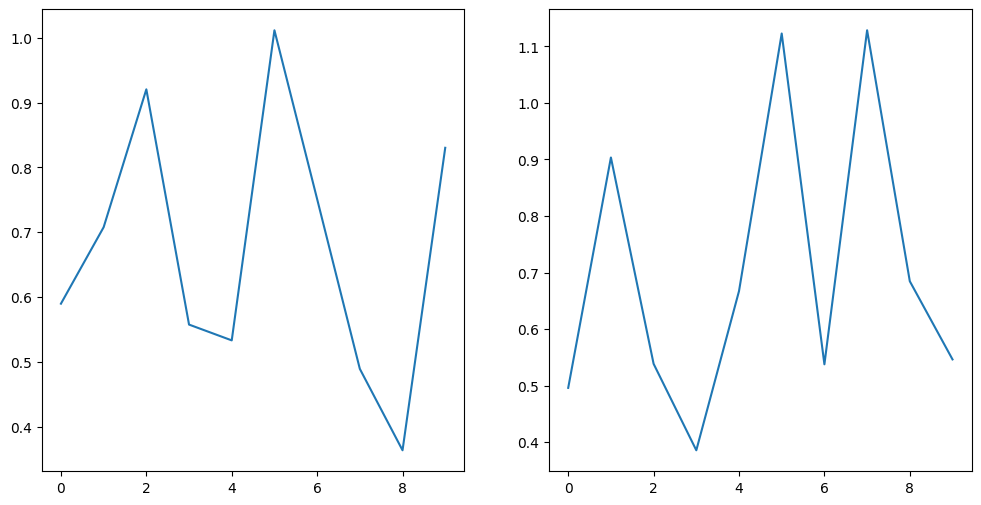

In [16]:
plot_losses(gan, max_epochs)

dd

In [18]:
MODEL_PATH = checkpoint_dir / 'gan'

In [19]:
torch.save(gan.state_dict(), MODEL_PATH)

In [20]:
gan_2 = GAN(percentile)
gan_2.load_state_dict(torch.load(MODEL_PATH))
gan_2.eval()

GAN(
  (G): Generator(
    (down1): Sequential(
      (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (down2): Sequential(
      (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (inv_res_h_1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv3d(64, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): ConvBNReLU(
          (0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=32, bias=False)
       

In [21]:
gan_2.prepare_data()
train_loader = gan_2.train_dataloader()

Re-generated trained samples

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


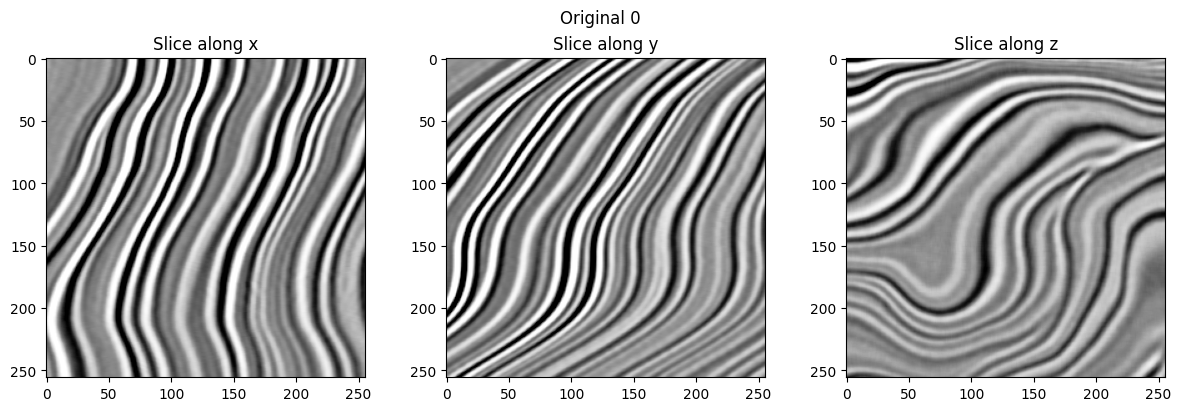

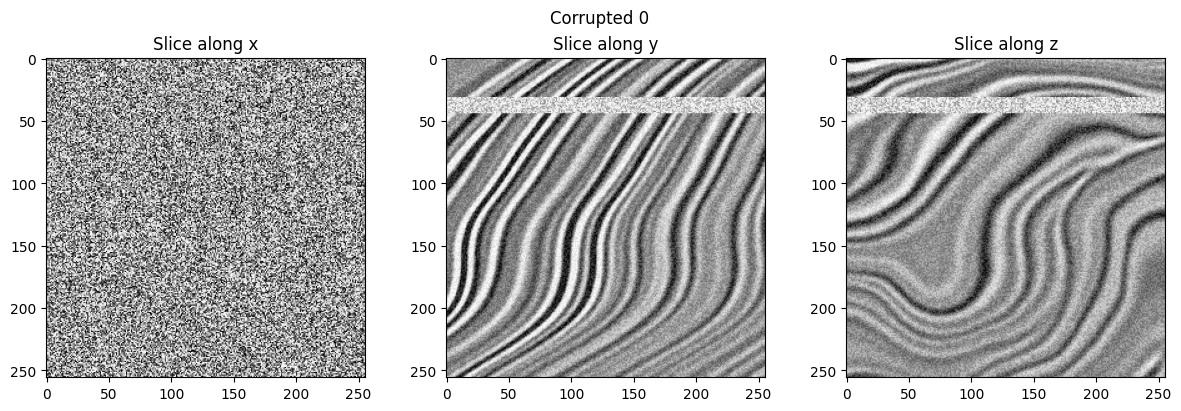

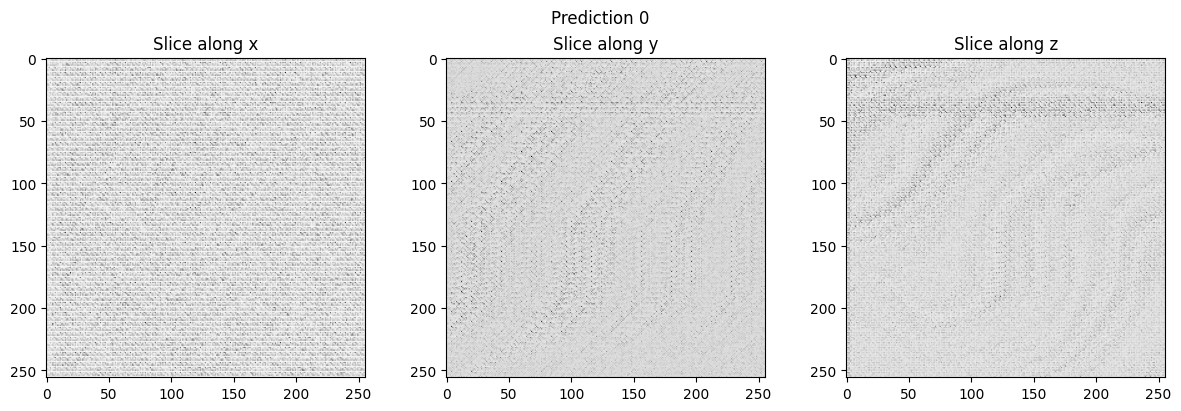

In [22]:
keys = ['target','image', 'prediction']
labels = ['Original','Corrupted', 'Prediction']

trainer = pl.Trainer()

for i, batch in enumerate(train_loader):
    prediction = gan_2(batch['image'])
    batch['prediction'] = prediction
    visualize_volumes(batch, i, keys, labels, True)

#### Some random stuff 

In [23]:
gan.prepare_data()

In [24]:
dataiter = iter(gan.train_data)

In [25]:
sample = (next(dataiter))

In [26]:
sample.keys()

dict_keys(['target', 'image', 'mask'])

In [27]:
sample['image'].shape

torch.Size([1, 256, 256, 256])

In [28]:
original_pt = sample['target'].as_tensor()[0]
corrupted_pt = sample['image'].as_tensor()[0]

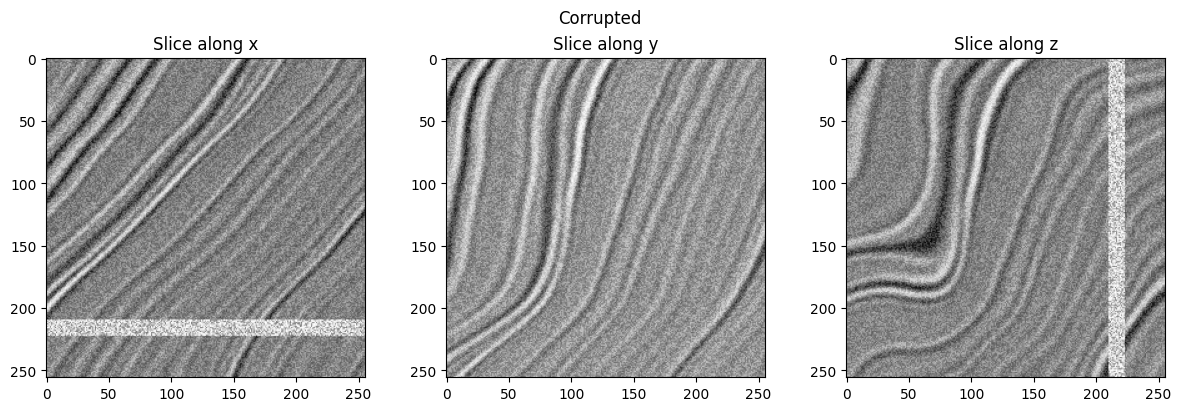

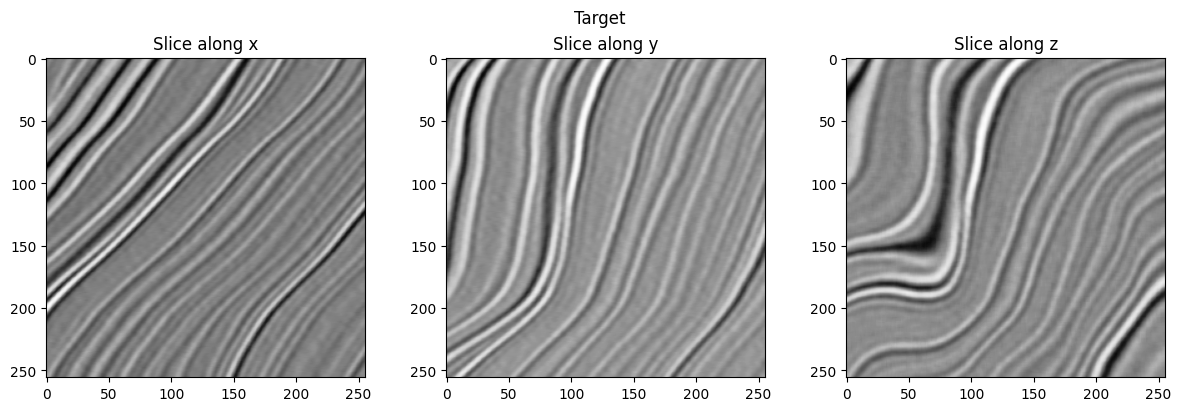

In [29]:
visualize_slices(nib.Nifti1Image(corrupted_pt.numpy(), np.eye(4)), 100, 100, 100, 'Corrupted')
visualize_slices(nib.Nifti1Image(original_pt.numpy(), np.eye(4)), 100, 100, 100, 'Target')

In [30]:
perturbated_original = original_pt.numpy() + np.random.rand(*original_pt.shape) * 0.5

In [31]:
perturbated_corrupted = corrupted_pt + (sample['mask'][0] * torch.rand(*corrupted_pt.shape))

In [32]:
torch.sum(corrupted_pt + sample['mask'][0] * torch.rand(*sample['mask'][0].shape))

tensor(11495646.)

In [33]:
torch.sum(sample['mask'][0] * torch.rand(*corrupted_pt.shape))

tensor(425500.8125)

In [34]:
corrupted_pt[sample['mask'].numpy()[0]]

tensor([0.5820, 0.5902, 0.0218,  ..., 0.0276, 0.0903, 0.0269])

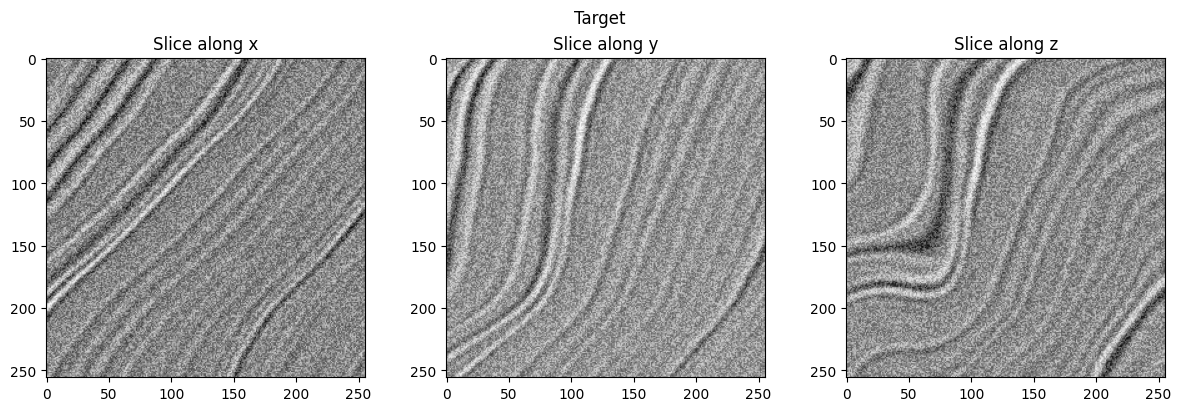

In [36]:
visualize_slices(nib.Nifti1Image(perturbated_original, np.eye(4)), 100, 100, 100, 'Target')